# Imports

In [37]:
from google.colab import drive
drive.mount('/content/drive')

!pip install rasterio

import pandas as pd
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import geopandas as gpd
import math
from PIL import Image
from PIL import ImageEnhance
from rasterio.warp import transform
from rasterio.features import rasterize
import logging
logging.getLogger('rasterio._env').setLevel(logging.ERROR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# View all input planet images

In [40]:
brightness_factor = 1.5

data_folder_path = '/content/drive/MyDrive/img-label-correction-SAM/data/raw/'

level_list=['1','2','3']
complexity_list=['A','B','C']

for level in level_list:
  for complexity in complexity_list:
    level_path='Level '+level+'/'+complexity+level
    tif_path=data_folder_path+level_path
    tif_list= [f[:-4] for f in os.listdir(tif_path) if f.endswith('.tif')]
    for uid in  tif_list:
      #if uid in valid_uid:
        target_uid=uid
        geotiff_path = tif_path+'/'+uid+'.tif'
        base_tiff =uid+'.tif'

        with rasterio.open(geotiff_path) as geotiff_reader:
          allbands_array = geotiff_reader.read()
        tiff_image = np.transpose(allbands_array, (1, 2, 0))
        tiff_image_uint8 = tiff_image.astype(np.uint8)
        tiff_image_rgb=tiff_image_uint8[:, :, :3]

        tiff_image_rgb_norm = tiff_image_rgb / 255.0
        tiff_image_rgb_bright = np.clip(tiff_image_rgb_norm * brightness_factor, 0, 1)
        tiff_image_rgb_bright_uint8 = (tiff_image_rgb_bright * 255).astype(np.uint8)

        print(uid)
        plt.figure(figsize=(4, 4))
        plt.imshow(tiff_image_rgb_bright_uint8)
        #plt.title(uid)
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

# View details of planet image
* tif image
* starting polygon
* ground truth polygon
* sam output masks png

In [41]:
brightness_factor = 1.5
valid_uid='0d8eea0e-e5c6-5ea2-ad38-f2050a03c131'#'95d5860f-c615-5903-833c-bbcb2a70ab5e'

data_folder_path = '/content/drive/MyDrive/img-label-correction-SAM/data/raw/'
good_geojson_path = data_folder_path+'GroundTruth_Final_20250625.geojson'
bad_geojson_path = data_folder_path+'Starting_Polygons_20250625.geojson'

level_list=['1','2','3']
complexity_list=['A','B','C']

for level in level_list:
  for complexity in complexity_list:
    level_path='Level '+level+'/'+complexity+level
    tif_path=data_folder_path+level_path
    tif_list= [f[:-4] for f in os.listdir(tif_path) if f.endswith('.tif')]
    for uid in  tif_list:
      if uid in valid_uid:
        target_uid=uid
        # print(f"Processing {uid}")
        # print()
        geotiff_path = tif_path+'/'+uid+'.tif'
        base_tiff =uid+'.tif'

        with rasterio.open(geotiff_path) as geotiff_reader:
          allbands_array = geotiff_reader.read()
        tiff_image = np.transpose(allbands_array, (1, 2, 0))
        tiff_image_uint8 = tiff_image.astype(np.uint8)
        tiff_image_rgb=tiff_image_uint8[:, :, :3]

        good_jsondf = gpd.read_file(good_geojson_path)
        good_json_uid_record = good_jsondf[good_jsondf['UID'] == uid]
        bad_jsondf = gpd.read_file(bad_geojson_path)
        bad_json_uid_record = bad_jsondf[bad_jsondf['UID'] == uid]

        if len(bad_json_uid_record) == 0:
          print('bad polygon missing')
        else:
          good_polygon_geom = good_json_uid_record.iloc[0].geometry
          bad_polygon_geom = bad_json_uid_record.iloc[0].geometry

          good_polygon_mask = rasterize(
              [(good_polygon_geom, 1)],
              out_shape=(geotiff_reader.height, geotiff_reader.width),
              transform=geotiff_reader.transform,
              fill=0,
              all_touched=True
          ).astype(bool)

          bad_polygon_mask = rasterize(
              [(bad_polygon_geom, 1)],
              out_shape=(geotiff_reader.height, geotiff_reader.width),
              transform=geotiff_reader.transform,
              fill=0,
              all_touched=True
          ).astype(bool)

          centroid_lat = float(bad_json_uid_record['CentroidLat'].iloc[0])
          centroid_lon = float(bad_json_uid_record['CentroidLon'].iloc[0])
          source_crs="EPSG:4326"
          destination_crs=geotiff_reader.crs
          x, y = transform(source_crs, destination_crs, xs=[centroid_lon], ys=[centroid_lat])
          geotiff_centroid_x, geotiff_centroid_y = geotiff_reader.index(x, y)

          tiff_image_rgb_norm = tiff_image_rgb / 255.0
          tiff_image_rgb_bright = np.clip(tiff_image_rgb_norm * brightness_factor, 0, 1)
          tiff_image_rgb_bright_uint8 = (tiff_image_rgb_bright * 255).astype(np.uint8)

          minx, miny, maxx, maxy = bad_polygon_geom.bounds
          top_left = geotiff_reader.index(minx, maxy)
          bottom_right = geotiff_reader.index(maxx, miny)
          pad = 0
          input_box = np.array([
            max(0, top_left[1] - pad),
            max(0, top_left[0] - pad),
            min(tiff_image_rgb.shape[1], bottom_right[1] + pad),
            min(tiff_image_rgb.shape[0], bottom_right[0] + pad)
          ])

          x_min, y_min, x_max, y_max = input_box
          rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor='lime',
            facecolor='none',
            label='Bounding Box'
          )

          print(uid)
          print()
          print("Input Image details")
          print()
          plt.figure(figsize=(12, 4))
          plt.subplot(1, 3, 1)
          plt.imshow(tiff_image_rgb_bright_uint8)
          plt.title("RGB Input Image")
          plt.axis('off')

          plt.subplot(1, 3, 2)
          plt.imshow(tiff_image_rgb_bright_uint8)
          plt.imshow(bad_polygon_mask, cmap='gray', alpha=0.2)
          plt.title("Starting Polygon")
          plt.axis('off')

          plt.subplot(1, 3, 3)
          plt.imshow(tiff_image_rgb_bright_uint8)
          plt.imshow(good_polygon_mask, cmap='gray', alpha=0.2)
          plt.title("Ground Truth Polygon")
          plt.axis('off')
          plt.show()
          print()
          print("Input Prompts to SAM models")
          print()
          plt.figure(figsize=(12, 4))
          plt.subplot(1, 3, 1)
          plt.imshow(tiff_image_rgb_bright_uint8)
          plt.scatter(geotiff_centroid_x, geotiff_centroid_y, c='red',marker='x')
          plt.title("Point Prompt")
          plt.axis('off')

          plt.subplot(1, 3, 2)
          plt.imshow(tiff_image_rgb_bright_uint8)
          plt.imshow(np.clip(tiff_image_rgb * 1.5, 0, 255).astype(np.uint8))
          plt.gca().add_patch(rect)
          plt.title("Box Prompt")
          plt.axis('off')

          plt.subplot(1, 3, 3)
          plt.imshow(tiff_image_rgb_bright_uint8)
          plt.imshow(bad_polygon_mask, cmap='gray', alpha=0.2)
          plt.title("Mask Prompt")
          plt.axis('off')
          plt.show()

output_folder_path = '/content/drive/MyDrive/img-label-correction-SAM/output/'
output_metadata_folder_path = output_folder_path+'metadata/'
manifest_path = output_metadata_folder_path+"rts_auto_segmentation_manifest.csv"
input_folder = output_folder_path+'images/'

df = pd.read_csv(manifest_path)
uid_df = df[df['uid'] == valid_uid].sort_values(by='iou', ascending=False)

num_images = len(uid_df)
cols = 4
rows = math.ceil(num_images / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axs = axs.flatten()

print()
print("Output RTS boundaries from SAM models")
print()

for i, (idx, row) in enumerate(uid_df.iterrows()):
  filename = row['output_fileid']
  filename_short = filename[filename.index("sam"):] if "sam" in filename else filename
  iou = row['iou']

  filename_display= str(iou)+' '+filename_short
  png_filepath = input_folder+filename+'.png'
  img = Image.open(png_filepath)

  img = Image.open(png_filepath).convert('RGB')
  enhancer = ImageEnhance.Brightness(img)
  bright_img = enhancer.enhance(brightness_factor)

  ax = axs[i]
  ax.imshow(bright_img)
  ax.set_title(filename_display, fontsize=10, fontweight='bold')
  ax.axis('off')
  for j in range(i + 1, rows * cols):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# View Geojson boundries of the masks

Level 1/A1
Processing 95d5860f-c615-5903-833c-bbcb2a70ab5e


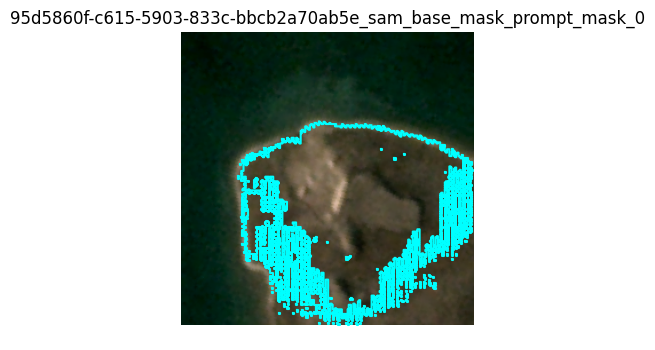

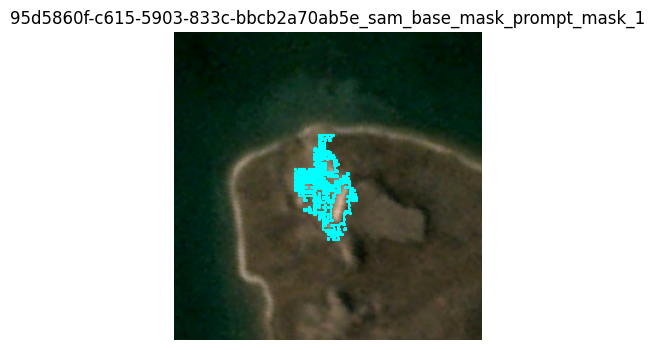

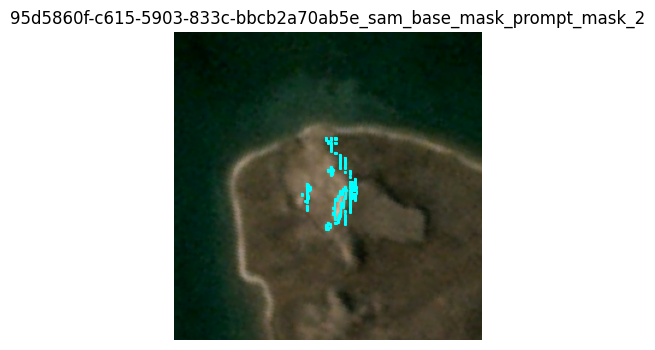

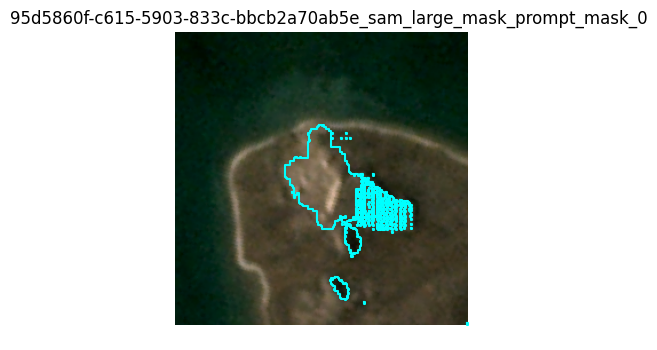

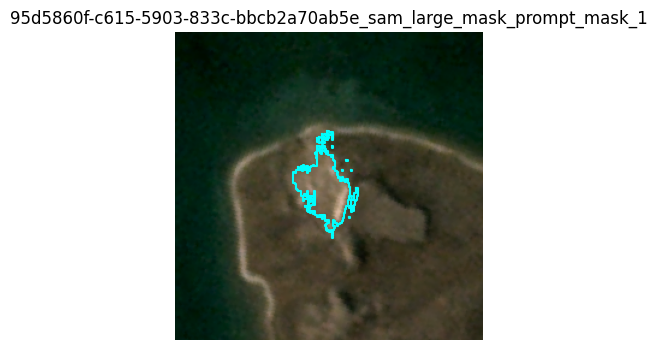

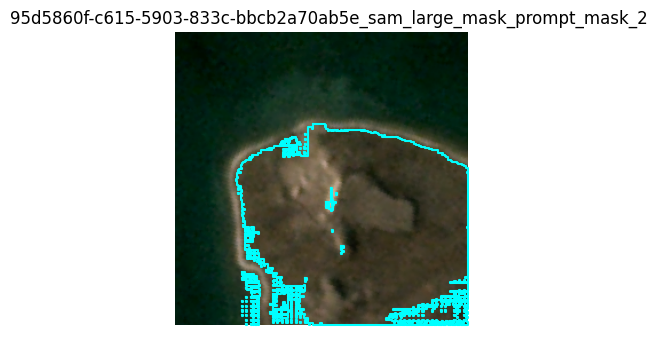

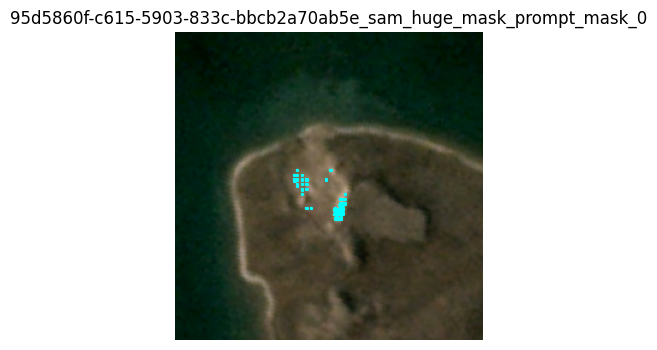

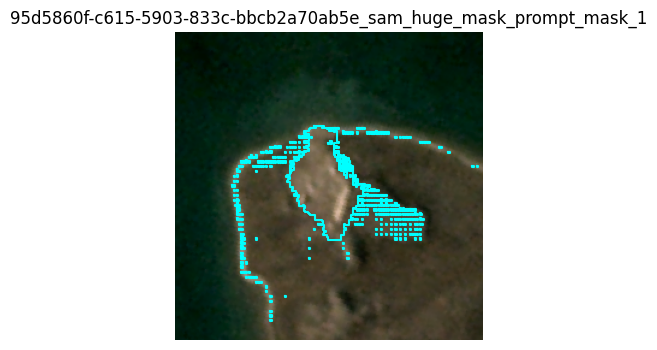

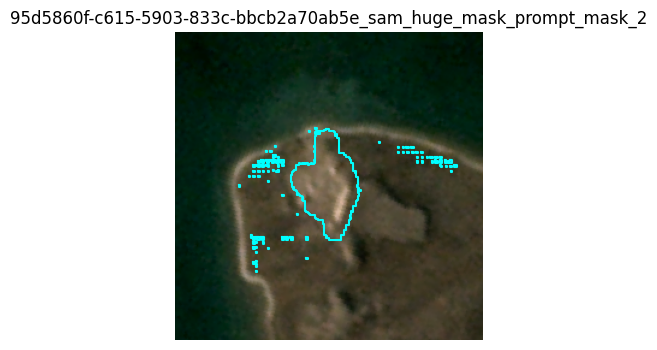

Level 1/B1
Level 1/C1
Level 2/A2
Level 2/B2
Level 2/C2
Level 3/A3
Level 3/B3
Level 3/C3
Processing Completed


In [36]:
valid_uid_list=['95d5860f-c615-5903-833c-bbcb2a70ab5e']#,'695c921c-0b42-5e3b-a88a-23924816bc08']

data_folder_path = '/content/drive/MyDrive/img-label-correction-SAM/data/raw/'
metadata_folder_path = '/content/drive/MyDrive/img-label-correction-SAM/output/metadata/'
manifest_path = metadata_folder_path+"rts_auto_segmentation_manifest.csv"

geojson_path = metadata_folder_path+'predicted_polygons_sam_mask_prompt.geojson'

level_list=['1','2','3']
complexity_list=['A','B','C']

for level in level_list:
  for complexity in complexity_list:
    level_path='Level '+level+'/'+complexity+level
    tif_path=data_folder_path+level_path
    tif_list= [f[:-4] for f in os.listdir(tif_path) if f.endswith('.tif')]
    print(level_path)
    for uid in  tif_list:
      if uid in valid_uid_list:
        target_uid=uid
        print(f"Processing {uid}")
        # ==============================================================================
        # Process Tiff
        # ==============================================================================
        geotiff_path = tif_path+'/'+uid+'.tif'
        base_tiff =uid+'.tif'
        with rasterio.open(geotiff_path) as geotiff_reader:
          allbands_array = geotiff_reader.read()

        tiff_image = np.transpose(allbands_array, (1, 2, 0))
        tiff_image_uint8 = tiff_image.astype(np.uint8)
        tiff_image_rgb=tiff_image_uint8[:, :, :3]
        # ==============================================================================
        # Process Geojson
        # ==============================================================================

        sam_jsondf = gpd.read_file(geojson_path)
        sam_json_uid_record = sam_jsondf[sam_jsondf['UID'] == uid]
        for index, row in sam_json_uid_record.iterrows():
          predict_polygon_geom = row['geometry']
          filename=      row['output_fileid']

          plt.figure(figsize=(4, 4))
          plt.imshow(tiff_image_rgb)

          if predict_polygon_geom.geom_type == 'MultiPolygon':
            polygons = predict_polygon_geom.geoms
          else:
            polygons = [predict_polygon_geom]

          for poly in polygons:
            x, y = poly.exterior.xy
            pixel_coords = [~geotiff_reader.transform * (x[i], y[i]) for i in range(len(x))]
            x_pix = [p[0] for p in pixel_coords]
            y_pix = [p[1] for p in pixel_coords]
            plt.plot(x_pix, y_pix, color='cyan', linewidth=1.5)

          plt.title(filename)
          plt.axis('off')
          plt.show()
print("Processing Completed")
